In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/bbuser/Desktop/DataScience-Brain-Bytes/Team_members/from_alzahra/data/surat_uncleaned.csv")

In [3]:
print("=== First 5 Rows ===")
print(df.head())
print("\n=== Dataset Info ===")
print(df.info())

=== First 5 Rows ===
                                       property_name areaWithType square_feet  \
0          2 BHK Apartment for Sale in Dindoli Surat  Carpet Area    644 sqft   
1           2 BHK Apartment for Sale in Althan Surat   Super Area   1278 sqft   
2          2 BHK Apartment for Sale in Pal Gam Surat   Super Area   1173 sqft   
3     2 BHK Apartment for Sale in Jahangirabad Surat  Carpet Area    700 sqft   
4  2 BHK Apartment for Sale in Orchid Fantasia, P...   Super Area   1250 sqft   

       transaction            status        floor      furnishing  \
0     New Property  Poss. by Oct '24  5 out of 10     Unfurnished   
1     New Property  Poss. by Jan '26  6 out of 14     Unfurnished   
2           Resale     Ready to Move  5 out of 13  Semi-Furnished   
3     New Property     Ready to Move  6 out of 14     Unfurnished   
4  Orchid Fantasia      New Property  Unfurnished               2   

        facing                                        description  \
0       

In [4]:
#Check ALL column names in the DataFrame
print("All columns in the DataFrame:")
print(df.columns.tolist())

All columns in the DataFrame:
['property_name', 'areaWithType', 'square_feet', 'transaction', 'status', 'floor', 'furnishing', 'facing', 'description', 'price_per_sqft', 'price']


In [5]:
df.describe()

,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
count,4525,4525,4525,4421,4524,4480,4185,3936,3154,4157,4525
unique,1992,6,1399,38,138,222,78,176,2588,2134,841
top,3 BHK Apartment for Sale in Vesu Surat,Super Area,1000 sqft,Resale,Ready to Move,Resale,Unfurnished,East,Multistorey apartment is available for sale. I...,"₹5,000 per sqft",Call for Price
freq,93,2599,77,2197,3078,431,2322,1487,35,64,173


In [6]:
# Check for missing values
print(df.isnull().sum())

property_name        0
areaWithType         0
square_feet          0
transaction        104
status               1
floor               45
furnishing         340
facing             589
description       1371
price_per_sqft     368
price                0
dtype: int64


In [7]:
df.dtypes

property_name     object
areaWithType      object
square_feet       object
transaction       object
status            object
floor             object
furnishing        object
facing            object
description       object
price_per_sqft    object
price             object
dtype: object

In [8]:
#Clean 'square_feet'
df['square_feet'] = df['square_feet'].astype(str).str.extract(r'(\d+)')
df['square_feet'] = pd.to_numeric(df['square_feet'], errors='coerce')

# Convert from sqm to sqft if 'sqm' found in description
df['description'] = df['description'].astype(str)
sqm_mask = df['description'].str.contains('sqm', case=False, na=False)
df.loc[sqm_mask, 'square_feet'] = df.loc[sqm_mask, 'square_feet'] * 10.764


In [9]:
#Clean price columns
df['price_per_sqft'] = df['price_per_sqft'].astype(str).str.replace('[₹, per sqft]', '', regex=True).str.strip()
df['price_per_sqft'] = pd.to_numeric(df['price_per_sqft'], errors='coerce')

df['price'] = df['price'].astype(str).str.replace('[₹, Lac]', '', regex=True).str.strip()
df['price'] = pd.to_numeric(df['price'], errors='coerce') * 100000


In [10]:
#Clean 'floor' column
df['floor'] = df['floor'].astype(str)
df['floor_num'] = df['floor'].str.extract('(\d+)').astype(float)
df['total_floors'] = df['floor'].str.extract('out of (\d+)').astype(float)

df['floor_num'] = df['floor_num'].fillna(df['floor_num'].median())
df['total_floors'] = df['total_floors'].fillna(df['total_floors'].median())


In [11]:
#Standardize categorical columns
df['furnishing'] = df['furnishing'].astype(str).str.lower().str.strip()
df['furnishing'] = df['furnishing'].replace({
    '1': 'unfurnished', '2': 'semi-furnished', '3': 'furnished'
})

df['facing'] = df['facing'].astype(str).str.lower().str.strip()
df['facing'] = df['facing'].replace({
    'north - east': 'northeast', 'south - west': 'southwest',
    'south - east': 'southeast', 'north - west': 'northwest',
    '1': 'east', '2': 'west', '3': 'north', '4': 'south'
})


In [12]:
#Extract property type and location
df['property_name'] = df['property_name'].astype(str)
df['property_type'] = df['property_name'].str.extract('(\\d+ BHK|Plot/Land|Shop|Office Space|Villa|Penthouse|House|Industrial)', expand=False)
df['property_type'] = df['property_type'].str.lower().str.strip().fillna('apartment')

df['location'] = df['property_name'].str.extract('in (.*?) Surat', expand=False).str.strip()


In [13]:
#Final cleanup
df = df.drop(columns=['floor', 'description', 'property_name'], errors='ignore')
df = df.fillna(method='ffill')


C:\Users\bbuser\AppData\Local\Temp\ipykernel_5016\1260379123.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [14]:
#Encode categorical features
categorical_cols = ['areaWithType', 'transaction', 'status', 'furnishing', 'facing', 'property_type', 'location']
label_encoders = {}

for col in categorical_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [15]:
#Normalize numerical features
scaler = StandardScaler()
num_cols = ['square_feet', 'price_per_sqft', 'floor_num', 'total_floors']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [16]:
#Model Preparation
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 388983.75769534335
MSE: 546505599079.30133
R2 Score: 0.8613787927535206


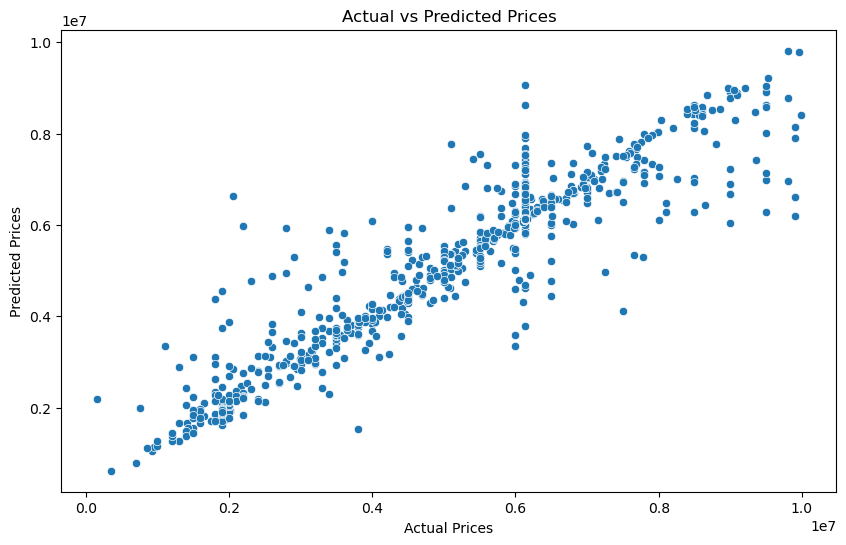

In [19]:
# Visualization
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()